<a href="https://colab.research.google.com/github/yuracode/hsprogramming/blob/main/0.%E5%AE%9F%E8%A3%85%E3%83%87%E3%83%A2%E3%83%B3%E3%82%B9%E3%83%88%E3%83%AC%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ノートブックの概要

このノートブックでは、Gradioライブラリを使って様々な画像処理およびAI関連のアプリケーションを開発・実行しています。各セクションでは、QRコード生成、AI画像生成、総合画像処理アプリ、リアルタイム物体認識アプリ、そして画像加工とAI分析を組み合わせたオリジナルアプリが紹介されています。



#### Colaboratoryの簡単な使い方

右上の「接続」を押します。

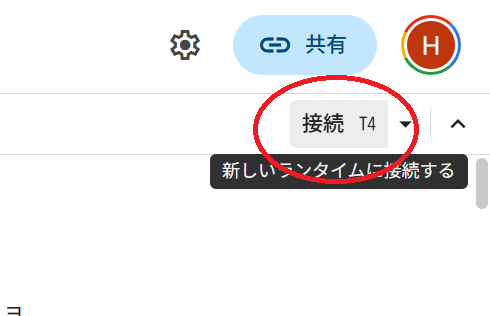

#### 行番号のつけ方

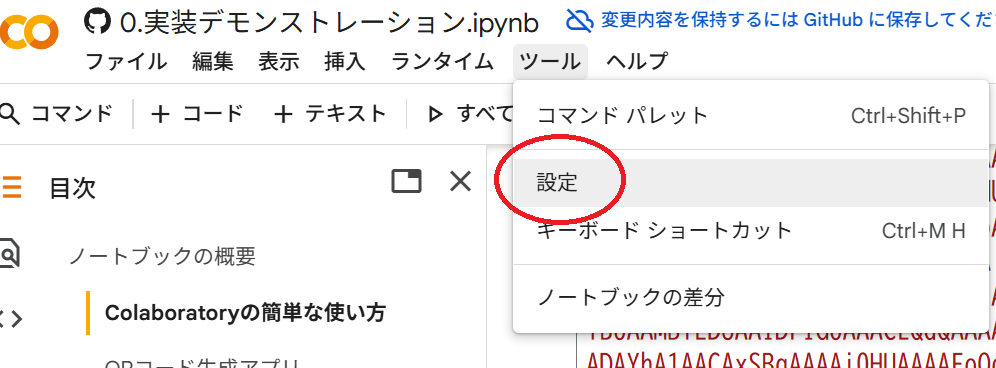

#### 行番号をチェックする

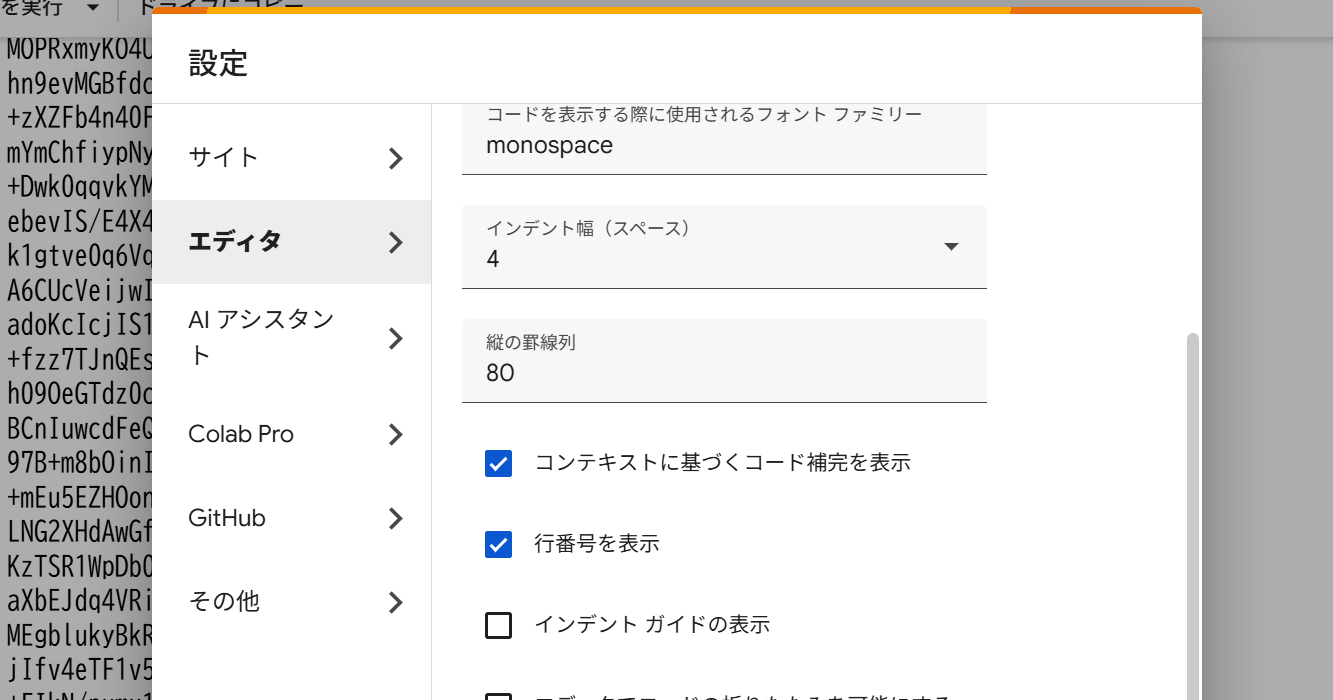

#### 目次を開いておく

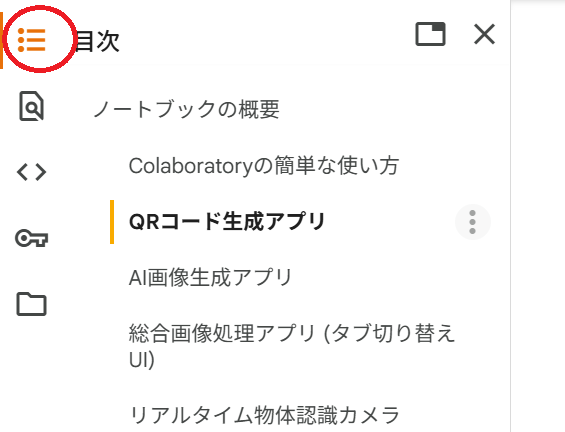

---

### 1. QRコード生成アプリ

このセクションのコードは、入力されたテキストからQRコード画像を生成し、それを表示するシンプルなWebアプリケーションを構築します。

- **機能:** テキストを入力すると、対応するQRコード画像を生成します。
- **使用ライブラリ:** `gradio` (Web UI構築), `qrcode` (QRコード生成), `Pillow` (画像処理), `io` (メモリ上でのデータ操作)
- **コードのポイント:** `qrcode.make()`でQRコードオブジェクトを作成し、`BytesIO`を使ってメモリ上で画像データを一時的に扱い、Gradioの`gr.Interface`でUIを作成しています。

In [ ]:
!pip install torch torchvision qrcode gradio -qq

In [ ]:
# Gradio, qrcode, Pillow(Image)に加えて、
# メモリ上でデータをファイルのように扱うための`BytesIO`をインポートします。
import gradio as gr
import qrcode
from io import BytesIO
from PIL import Image

# 入力されたテキストからQRコード画像を生成する`generate_qr`関数を定義します。
def generate_qr(text):
    # `qrcode.make()`を使い、テキストをQRコードの画像オブジェクトに変換します。
    qr_img = qrcode.make(text)

    # --- Colab等の環境でより安定して動作させるための処理 ---
    # `BytesIO`を使い、画像データを一時的に保存するためのメモリ領域(`buf`)を用意します。
    buf = BytesIO()
    # 生成したQRコード画像を、PNG形式でメモリ領域(`buf`)に書き込みます。
    qr_img.save(buf, format="PNG")
    # 書き込んだデータを最初から読み込めるように、メモリ上のカーソルを先頭に戻します。
    buf.seek(0)
    # メモリ領域から画像データを読み込み、改めてPillowの画像オブジェクトとして開きます。
    img = Image.open(buf)

    # 安全な形式に変換された画像データを返します。
    return img

# GradioのInterfaceを使い、Web UIを設計します。
demo = gr.Interface(fn=generate_qr, inputs="text", outputs="image")

# 作成したUIを、外部からアクセス可能な公開URLで起動します。
demo.launch(share=True)


### 2. AI画像生成アプリ

このセクションでは、`diffusers`ライブラリを使って、テキストの指示（プロンプト）に基づいて画像を生成するWebアプリケーションを構築します。Stable Diffusionモデルを利用しています。

- **機能:** テキストプロンプトを入力すると、AIがその内容に基づいた画像を生成します。
- **使用ライブラリ:** `gradio` (Web UI構築), `diffusers` (画像生成モデルの利用)
- **コードのポイント:** "stabilityai/stable-diffusion-2-1-base" モデルを読み込み、`pipe()`にプロンプトを渡して画像を生成します。Gradioの`gr.Interface`で入力（テキスト）と出力（画像）を設定しています。

In [ ]:
# Gradioライブラリと、画像生成AIを簡単に扱うための`diffusers`ライブラリをインポートします。
import gradio as gr
from diffusers import DiffusionPipeline

# stabilityaiが提供する学習済みの画像生成AIモデル（Stable Diffusion）を読み込みます。
# 初回実行時は、モデルのダウンロードに数分かかることがあります。
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base")
# 読み込んだAIモデルをGPUに転送します。これにより、画像生成が高速になります。
pipe = pipe.to("cuda")

# プロンプト（テキストの指示）を受け取り、画像を生成する関数を定義します。
def generate_image(prompt):
    # AIモデル(`pipe`)にプロンプトを渡し、画像生成を実行します。
    # 結果の中から最初の画像(`.images[0]`)を取り出します。
    image = pipe(prompt).images[0]
    # 生成された画像を返します。
    return image

# GradioのInterfaceを使い、Web UIを設計します。
demo = gr.Interface(fn=generate_image,
                    inputs="text",
                    outputs="image",
                    # `title=`でUIのタイトルを、`description=`で説明文を設定できます。
                    title="AIイラストレーター",
                    description="好きな言葉（プロンプト）を入力して、画像を作ってみよう！")

# 作成したUI(`demo`)を、外部からアクセス可能な公開URLで起動します。
demo.launch(share=True)

---

### 3. 総合画像処理アプリ (タブ切り替えUI)

このセクションのコードは、複数の画像処理・分析機能を一つのWebアプリケーションに統合しています。タブを使って「画像加工」と「AI画像分析」の機能を切り替えられます。

- **機能:**
    - **画像加工:** アップロードした画像にフィルター（白黒、回転）、ぼかし、透かし文字を適用します。
    - **AI画像分析:** アップロードした画像をResNet50モデルで分析し、写っているものの確率を表示します（上位5件）。
- **使用ライブラリ:** `gradio`, `Pillow`, `numpy`, `torch`, `torchvision`, `requests`
- **コードのポイント:** `gr.Blocks()`と`gr.Tabs()`を使って複雑なUIレイアウトを構築しています。各タブ内にそれぞれの機能に関連するUI部品とロジック（`image_processing`関数と`predict`関数）を配置しています。

In [ ]:
# 必要なライブラリをすべてインポート
import gradio as gr
from PIL import Image, ImageFilter, ImageDraw
import numpy as np
import torch
import torchvision.transforms.functional as F
from torchvision.models import resnet50
import requests

# --- AIモデルとラベルの準備 ---
# この準備は一度だけ行います
try:
    model = resnet50(pretrained=True)
    model.eval()

    response = requests.get("https://git.io/JJkYN")
    labels = response.text.split("\n")
    print("AIモデルの準備が完了しました。")
except Exception as e:
    print(f"AIモデルの準備中にエラーが発生しました: {e}")
    model = None
    labels = None

# --- 1. 画像加工のロジック（前回のコードと同じ） ---
def image_processing(img, filter_type, blur_level, watermark_text):
    if img is None:
        return None, "画像をアップロードしてください。"
    processed_img = img.copy()
    if filter_type == "白黒":
        processed_img = processed_img.convert('L')
    elif filter_type == "90度回転":
        processed_img = processed_img.rotate(90, expand=True)
    if blur_level > 0:
        processed_img = processed_img.filter(ImageFilter.GaussianBlur(radius=blur_level))
    if watermark_text:
        draw = ImageDraw.Draw(processed_img)
        draw.text((10, 10), watermark_text, fill="white", stroke_width=1, stroke_fill="black")
    return processed_img, f"処理完了：{filter_type}"

# --- 2. AIによる画像分析のロジック ---
# (教材のコードを関数として整理)
@torch.no_grad()
def predict(input_img):
    if model is None or labels is None or input_img is None:
        return "AIモデルが準備できていないか、画像がありません。"

    # PIL ImageをPyTorchが扱えるTensorに変換
    img = F.resize(input_img, (224, 224))
    img = F.to_tensor(img)
    if img.shape[0] == 1: # 白黒画像の場合
        img = img.repeat(3, 1, 1)
    img = F.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = img.unsqueeze(0)

    # 推論の実行
    output = model(img).squeeze(0)
    probs = torch.nn.functional.softmax(output, dim=0).numpy()

    # 結果を{ラベル: 確率}の辞書形式で返す
    return {labels[i]: float(probs[i]) for i in range(1000)}

# --- GradioのUIを構築 ---
with gr.Blocks() as demo:
    gr.Markdown("# 総合画像処理アプリ")
    gr.Markdown("手動での画像加工と、AIによる画像分析ができます。")

    with gr.Tabs():
        # --- タブ1: 画像加工 ---
        with gr.TabItem("画像加工"):
            with gr.Row():
                with gr.Column():
                    proc_input = gr.Image(type="pil", label="加工したい画像をアップロード")
                    filter_radio = gr.Radio(["なし", "白黒", "90度回転"], label="フィルターを選択", value="なし")
                    blur_slider = gr.Slider(0, 10, value=0, label="ぼかしの強さ")
                    watermark_input = gr.Textbox(label="透かし文字")
                    proc_btn = gr.Button("画像処理を実行")
                with gr.Column():
                    proc_output = gr.Image(label="加工後の画像")
                    proc_status = gr.Textbox(label="処理ステータス")
            proc_btn.click(
                fn=image_processing,
                inputs=[proc_input, filter_radio, blur_slider, watermark_input],
                outputs=[proc_output, proc_status]
            )

        # --- タブ2: AI画像分析 ---
        with gr.TabItem("AI画像分析"):
            with gr.Row():
                with gr.Column():
                    ai_input = gr.Image(type="pil", label="分析したい画像をアップロード")
                    ai_btn = gr.Button("AI分析を実行")
                with gr.Column():
                    ai_output = gr.Label(num_top_classes=5, label="分析結果")
            ai_btn.click(
                fn=predict,
                inputs=ai_input,
                outputs=ai_output
            )

# 必要なライブラリのインストールを促すメッセージ
print("\nもし 'torch' や 'torchvision' がないというエラーが出たら、!pip install torch torchvision を実行してください。")
# アプリケーションの起動
demo.launch()

---

### 4. リアルタイム物体認識カメラ

このセクションでは、Webカメラの映像を使ってリアルタイムに物体認識を行うアプリケーションを構築します。`transformers`ライブラリの画像分類パイプラインを利用しています。

- **機能:** Webカメラに写っているものをAIがリアルタイムで認識し、その結果（ラベルと確信度）を表示します（上位10件）。
- **使用ライブラリ:** `gradio`, `transformers`, `torch`
- **コードのポイント:** `transformers.pipeline("image-classification", model="google/vit-base-patch16-224")`で画像分類モデルを簡単に読み込んでいます。Gradioの`gr.Image(sources=["webcam"])`でWebカメラ入力を指定し、`live=True`でリアルタイム処理を実現しています。

In [ ]:
# ================================================================
# 2コマ目・改：AIの思考を覗く！リアルタイム物体認識
# ================================================================

# ----------------------------------------------------------------
# ステップ1＆2：準備（初回と同じ）
# ----------------------------------------------------------------
!pip install transformers torch gradio --quiet
from transformers import pipeline
import gradio as gr

# ----------------------------------------------------------------
# ステップ3：AIモデルの読み込み（初回と同じ）
# ----------------------------------------------------------------
image_classifier = pipeline("image-classification", model="google/vit-base-patch16-224")

# ----------------------------------------------------------------
# ステップ4：AIの「思考」を可視化する「命令」を作る
# ----------------------------------------------------------------
# 予測結果のリストを、GradioのLabelコンポーネントが扱える形式（辞書）に変換する
# ----------------------------------------------------------------
def classify_image_realtime(image):
    # 画像が入力されていない場合はNoneを返す
    if image is None:
        return None

    predictions = image_classifier(image)

    # 予測結果を {ラベル名: 確信度スコア} の辞書形式に変換する
    # 上位10件だけを取り出す
    result_dict = {p['label']: p['score'] for p in predictions[:10]}
    return result_dict

# ----------------------------------------------------------------
# ステップ5：ライブカメラ対応の操作パネルを起動する
# ----------------------------------------------------------------
# inputsにWebカメラを指定し、live=True に設定することでリアルタイム処理が実現する
# ----------------------------------------------------------------
gr.Interface(fn=classify_image_realtime,
             inputs=gr.Image(sources=["webcam"], type="pil", label="Webカメラ"),
             outputs=gr.Label(num_top_classes=10, label="AIの認識結果（トップ10）"),
             title="👀 AIの思考を覗く！リアルタイム物体認識カメラ",
             description="Webカメラに身の回りのものを写してみてください。AIが何を認識しているか、その確信度と一緒にリアルタイムで表示します。",
             live=True).launch(share=True)

In [ ]:
# 必要なライブラリをすべてインポート
import gradio as gr
from PIL import Image, ImageFilter, ImageDraw
import numpy as np
import torch
import torchvision.transforms.functional as F
from torchvision.models import resnet50
import requests
from transformers import pipeline

# --- AIモデルとラベルの準備 ---
# この準備は一度だけ行います
try:
    # Image Classification model
    image_classifier = pipeline("image-classification", model="google/vit-base-patch16-224")
    # ResNet50 for image analysis
    model = resnet50(pretrained=True)
    model.eval()

    response = requests.get("https://git.io/JJkYN")
    labels = response.text.split("\n")
    print("AIモデルの準備が完了しました。")
except Exception as e:
    print(f"AIモデルの準備中にエラーが発生しました: {e}")
    image_classifier = None
    model = None
    labels = None

# --- 1. 画像加工のロジック ---
def image_processing(img, filter_type, blur_level, watermark_text):
    if img is None:
        return None, "画像をアップロードしてください。"
    processed_img = img.copy()
    if filter_type == "白黒":
        processed_img = processed_img.convert('L')
    elif filter_type == "90度回転":
        processed_img = processed_img.rotate(90, expand=True)
    if blur_level > 0:
        processed_img = processed_img.filter(ImageFilter.GaussianBlur(radius=blur_level))
    if watermark_text:
        draw = ImageDraw.Draw(processed_img)
        draw.text((10, 10), watermark_text, fill="white", stroke_width=1, stroke_fill="black")
    return processed_img, f"処理完了：{filter_type}"

# --- 2. AIによる画像分析のロジック ---
@torch.no_grad()
def predict(input_img):
    if model is None or labels is None or input_img is None:
        return "AIモデルが準備できていないか、画像がありません。"

    img = F.resize(input_img, (224, 224))
    img = F.to_tensor(img)
    if img.shape[0] == 1: # 白黒画像の場合
        img = img.repeat(3, 1, 1)
    img = F.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = img.unsqueeze(0)

    output = model(img).squeeze(0)
    probs = torch.nn.functional.softmax(output, dim=0).numpy()

    return {labels[i]: float(probs[i]) for i in range(1000)}

# --- 3. AIの「思考」を可視化する「命令」を作る (リアルタイム物体認識) ---
def classify_image_realtime(image):
    if image_classifier is None or image is None:
        return "AIモデルが準備できていないか、画像がありません。"

    predictions = image_classifier(image)

    result_dict = {p['label']: p['score'] for p in predictions[:10]}
    return result_dict

# --- GradioのUIを構築 ---
with gr.Blocks() as demo:
    gr.Markdown("# 総合画像処理アプリ")
    gr.Markdown("手動での画像加工、AIによる画像分析、リアルタイム物体認識ができます。")

    with gr.Tabs():
        # --- タブ1: 画像加工 ---
        with gr.TabItem("画像加工"):
            with gr.Row():
                with gr.Column():
                    proc_input = gr.Image(type="pil", label="加工したい画像をアップロード")
                    filter_radio = gr.Radio(["なし", "白黒", "90度回転"], label="フィルターを選択", value="なし")
                    blur_slider = gr.Slider(0, 10, value=0, label="ぼかしの強さ")
                    watermark_input = gr.Textbox(label="透かし文字")
                    proc_btn = gr.Button("画像処理を実行")
                with gr.Column():
                    proc_output = gr.Image(label="加工後の画像")
                    proc_status = gr.Textbox(label="処理ステータス")
            proc_btn.click(
                fn=image_processing,
                inputs=[proc_input, filter_radio, blur_slider, watermark_input],
                outputs=[proc_output, proc_status]
            )

        # --- タブ2: AI画像分析 ---
        with gr.TabItem("AI画像分析"):
            with gr.Row():
                with gr.Column():
                    ai_input = gr.Image(type="pil", label="分析したい画像をアップロード")
                    ai_btn = gr.Button("AI分析を実行")
                with gr.Column():
                    ai_output = gr.Label(num_top_classes=5, label="分析結果")
            ai_btn.click(
                fn=predict,
                inputs=ai_input,
                outputs=ai_output
            )

        # --- タブ3: リアルタイム物体認識 ---
        with gr.TabItem("リアルタイム物体認識"):
             with gr.Row():
                 with gr.Column():
                     realtime_input = gr.Image(sources=["webcam"], type="pil", label="Webカメラ")
                     # realtime_btn = gr.Button("AI分析を実行 (リアルタイム)") # ボタンは不要なので削除
                 with gr.Column():
                     realtime_output = gr.Label(num_top_classes=10, label="AIの認識結果（トップ10）")
             # Use change() for real-time updates from webcam
             realtime_input.change(
                 fn=classify_image_realtime,
                 inputs=realtime_input,
                 outputs=realtime_output,
                 live=True # Add live=True for real-time updates
             )


# 必要なライブラリのインストールを促すメッセージ
print("\nもし 'torch' や 'torchvision' がないというエラーが出たら、!pip install torch torchvision を実行してください。")
# アプリケーションの起動
demo.launch(share=True)

---

### 5. オリジナル画像加工＆AI分析アプリ (演習用)

このセクションは、上記の要素を組み合わせた演習用のアプリです。「画像加工フィルター」と「AI画像分析」の2つのタブを持ち、ユーザーがそれぞれの機能を実装できるようにテンプレートが提供されています。

- **機能:** (ユーザーがコードを実装することで完成)
    - **画像加工フィルター:** アップロード画像を白黒に加工する機能。（課題1）
    - **AI画像分析:** アップロード画像をAIが分析し、写っているもののトップ3を表示する機能。（課題2）
- **使用ライブラリ:** `gradio`, `Pillow`, `numpy`, `requests`, `torch`, `torchvision`
- **コードのポイント:** `image_filter`関数と`predict_image`関数の中に、ユーザーが画像加工とAI分析の具体的なコードを書き込むように促されています。AIモデル（ResNet50）の準備部分は提供されています。

In [ ]:
# 必要なライブラリをインポートします
# gradio: Web UIを簡単に作るためのライブラリ
# PIL (Pillow): 画像を加工するためのライブラリ
# numpy: 数値計算、特にAIでよく使われるライブラリ
# その他: AIモデルを動かすためのライブラリ
import gradio as gr
from PIL import Image
import numpy as np
import requests
import torch
from torchvision.models import resnet50
import torchvision.transforms.functional as F

# --- ここからAIの準備 (この部分は完成しています) ---
# 授業で使ったResNet50モデルとImageNetラベルを準備します
# この部分は一度だけ実行されます
try:
    model = resnet50(pretrained=True)
    model.eval()
    response = requests.get("https://git.io/JJkYN")
    labels = response.text.split("\n")
    print("AIモデルの準備OK！")
except Exception as e:
    print("AIモデルの準備中にエラーが発生しました:", e)
    model = None
    labels = None
# --- AIの準備ここまで ---


# --- 関数を定義するエリア ---

# 【課題１】画像加工用の関数を完成させよう！
# 1コマ目の最後に作った「白黒フィルター」の処理を思い出して書いてみよう！
def image_filter(input_img):
    print("画像加工ボタンが押されました！")
    if input_img is None:
        return None # 画像がなければ何もしない

    # ▼▼▼ ここに、Pillowを使った画像処理コードを追加しよう ▼▼▼
    # ヒント: input_img.convert('L') を使うと白黒にできます

    processed_img = input_img # 今はまだ何もしないので、この行を書き換えよう！

    # ▲▲▲ ここまで ▲▲▲

    return processed_img


# 【課題２】AI分析用の関数を完成させよう！
# 2コマ目に体験した「AIによる画像判定」のコードを参考に、中身を完成させよう！
def predict_image(input_img):
    print("AI分析ボタンが押されました！")
    if model is None or labels is None or input_img is None:
        return "AIモデルが準備できていないか、画像がありません。"

    # ▼▼▼ ここに、AIに画像を分析させるコードを追加しよう ▼▼▼
    # ヒント: 教材『3.Gradio(Webインタフェース)の基本.ipynb』の最後の部分を参考にしよう
    # 手順１：画像の前処理 (リサイズ、Tensorに変換、正規化)
    # 手順２：AIによる推論 (model(img) を呼び出す)
    # 手順３：結果を整形して、returnで返す
    img = F.resize(input_img, (224, 224))
    img = F.to_tensor(img)
    if img.shape[0] == 1: # 白黒画像の場合
        img = img.repeat(3, 1, 1)
    img = F.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = img.unsqueeze(0)


    # 推論の実行
    with torch.no_grad():
        output = None # ← AIの推論結果を入れる

    probs = None # ← outputを確率に変換した結果を入れる

    # # 推論の実行
    # with torch.no_grad():
    #     output = model(img).squeeze(0)
    # probs = torch.nn.functional.softmax(output, dim=0).numpy()

    # 結果を{ラベル: 確率}の辞書形式で返す
    result = {}
    # result = {labels[i]: float(probs[i]) for i in range(1000)}


    # ▲▲▲ ここまで ▲▲▲

    return result


# --- Web UIを作るエリア (この部分は完成しています) ---
# gr.Blocks() を使うと、より自由にUIを組み立てられます
with gr.Blocks() as demo:
    # アプリ全体のタイトル
    gr.Markdown("# オリジナル画像加工＆AI分析アプリ")

    # gr.Tabs() で機能を切り替えるタブを作ります
    with gr.Tabs():
        # 1つ目のタブ
        with gr.TabItem("画像加工フィルター"):
            gr.Markdown("## 好きな画像を加工してみよう！")
            with gr.Row():
                # 左側に配置するUI部品
                with gr.Column():
                    image_input_filter = gr.Image(type="pil", label="画像をアップロード")
                    process_button = gr.Button("加工する！")
                # 右側に配置するUI部品
                with gr.Column():
                    image_output_filter = gr.Image(label="加工後の画像")

            # ボタンが押されたら、どの関数を呼び出すか設定
            process_button.click(fn=image_filter, inputs=image_input_filter, outputs=image_output_filter)

        # 2つ目のタブ
        with gr.TabItem("AI画像分析"):
            gr.Markdown("## AIが写真に写っているものを当てるよ！")
            with gr.Row():
                # 左側に配置するUI部品
                with gr.Column():
                    image_input_ai = gr.Image(type="pil", label="画像をアップロード")
                    predict_button = gr.Button("AIに分析してもらう！")
                # 右側に配置するUI部品
                with gr.Column():
                    # gr.LabelはAIの分析結果を表示するのに便利です
                    label_output_ai = gr.Label(num_top_classes=3, label="分析結果")

            # ボタンが押されたら、どの関数を呼び出すか設定
            predict_button.click(fn=predict_image, inputs=image_input_ai, outputs=label_output_ai)


# アプリを起動します
print("アプリを起動します。URLが表示されたらクリックしてください。")
demo.launch()